<a href="https://colab.research.google.com/github/adigunaa/Capstone-Pictolang/blob/main/pretrained_Deep_CNN_based_on_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title Default title text
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



In [5]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
MOMENTUM = 0.9

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

170498071/170498071 [==============================] - 2s 0us/step


In [6]:
from PIL import Image

# Assuming X_train, X_val, and X_test are arrays of images
X_train_resized = np.array([np.array(Image.fromarray(x).resize((48, 48))) for x in X_train])
X_val_resized = np.array([np.array(Image.fromarray(x).resize((48, 48))) for x in X_val])
X_test_resized = np.array([np.array(Image.fromarray(x).resize((48, 48))) for x in X_test])

import cv2

# Assuming X_train, X_val, and X_test are arrays of images
X_train_resized = np.array([cv2.resize(x, (48, 48)) for x in X_train])
X_val_resized = np.array([cv2.resize(x, (48, 48)) for x in X_val])
X_test_resized = np.array([cv2.resize(x, (48, 48)) for x in X_test])


In [7]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [9]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [10]:
for layer in base_model.layers:
     layer.trainable = False

In [11]:
LEARNING_RATE = 0.001
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [13]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [14]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [15]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [16]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              verbose=1)

Epoch 1/15
1328/1328 [==============================] - 397s 298ms/step - loss: 0.2051 - accuracy: 0.5576 - val_loss: 0.1509 - val_accuracy: 0.6759
Epoch 2/15
1328/1328 [==============================] - 388s 292ms/step - loss: 0.1645 - accuracy: 0.6571 - val_loss: 0.1427 - val_accuracy: 0.6924
Epoch 3/15
1328/1328 [==============================] - 393s 296ms/step - loss: 0.1528 - accuracy: 0.6831 - val_loss: 0.1339 - val_accuracy: 0.7208
Epoch 4/15
1328/1328 [==============================] - 413s 311ms/step - loss: 0.1438 - accuracy: 0.7056 - val_loss: 0.1295 - val_accuracy: 0.7225
Epoch 5/15
1328/1328 [==============================] - 388s 292ms/step - loss: 0.1365 - accuracy: 0.7230 - val_loss: 0.1269 - val_accuracy: 0.7334
Epoch 6/15
1328/1328 [==============================] - 391s 294ms/step - loss: 0.1312 - accuracy: 0.7321 - val_loss: 0.1263 - val_accuracy: 0.7380
Epoch 7/15
1328/1328 [==============================] - 387s 291ms/step - loss: 0.1265 - accuracy: 0.7444 - val_

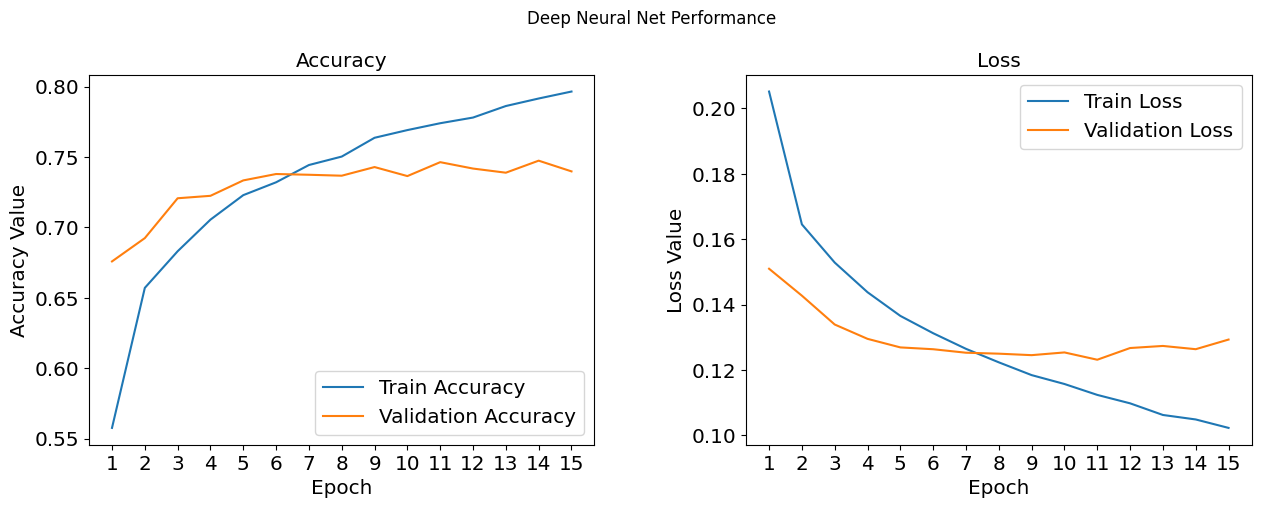

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,15+1)) #nilai 10 ini adalah jumlah epochs, ingat ubah setiap ganti jumlah epochs
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [28]:
predictions = model.predict(X_train_resized/255.)

1329/1329 [==============================] - 719s 541ms/step


In [48]:
# Konversi list ke numpy array
predictions = np.array(predictions)

# Ambil label yang memiliki nilai tertinggi secara umum
predicted_labels = predictions.argmax().tolist()  # Konversi kembali ke list jika diperlukan



In [50]:
get_metrics(true_labels=y_test, predicted_labels=predictions)



Accuracy: 0.0998
Precision: 0.1039
Recall: 0.0998
F1 Score: 0.0797


In [51]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [76]:
def plot_predictions(model, dataset, dataset_labels, label_dict, batch_size, grid_height, grid_width):

    # Generate random batch index
    random_batch_indx = np.random.choice(len(dataset), batch_size, replace=False)

    for img_idx in range(grid_height * grid_width):
        actual_label = label_dict.get(dataset_labels[random_batch_indx[img_idx]].argmax())
        # Lakukan prediksi menggunakan model
        # preds, confs_ = make_prediction(model, img_vector=dataset[random_batch_indx[img_idx]], label_dict=label_dict)
        # Lanjutkan dengan operasi lainnya...


In [77]:
plot_predictions(model=model,
                 dataset=X_train_resized/255.,
                 dataset_labels=Y_train,
                 label_dict=label_dict,
                 batch_size=16,
                 grid_height=4,
                 grid_width=4)


In [78]:
# Definisikan fungsi konversi TFLite
def convert_to_tflite(model, tflite_file):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Simpan model TFLite ke file
    with open(tflite_file, 'wb') as f:
        f.write(tflite_model)
    print(f"Model TensorFlow Lite berhasil disimpan ke: {tflite_file}")

# Ganti 'model' dengan model Keras Anda dan tentukan nama file untuk model TFLite
tflite_file = 'model.tflite'
convert_to_tflite(model, tflite_file)

Model TensorFlow Lite berhasil disimpan ke: model.tflite
